# FINAL PROJECT - House Prices: Advanced Regression Techniques

## AKHIL PATEL, SHARAD VARADARAJAN, MARK BARNETT, NATHAN NAM

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import csv
import math
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing
from xgboost.sklearn import XGBClassifier
import itertools

# Set the randomizer seed so results are the same each time.
np.random.seed(0)
plt.style.use('fivethirtyeight')

/Users/sharadvaradarajan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sharadvaradarajan/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Import the Data

In [2]:
df_train = pd.read_csv("Final Project/all/train.csv")
print("There are {} examples in our train dataset".format(len(df_train.index)))
df_test = pd.read_csv("Final Project/all/test.csv")
print("There are {} examples in our test dataset".format(len(df_test.index)))
df = df_train.append(df_test, ignore_index=True)
print("There are {} examples in our total dataset".format(len(df.index)))

df.head()

There are 1460 examples in our train dataset
There are 1459 examples in our test dataset
There are 2919 examples in our total dataset


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


## 1. Preliminary EDA

## 1.1 Feature Correlation and Outliers in Train Data

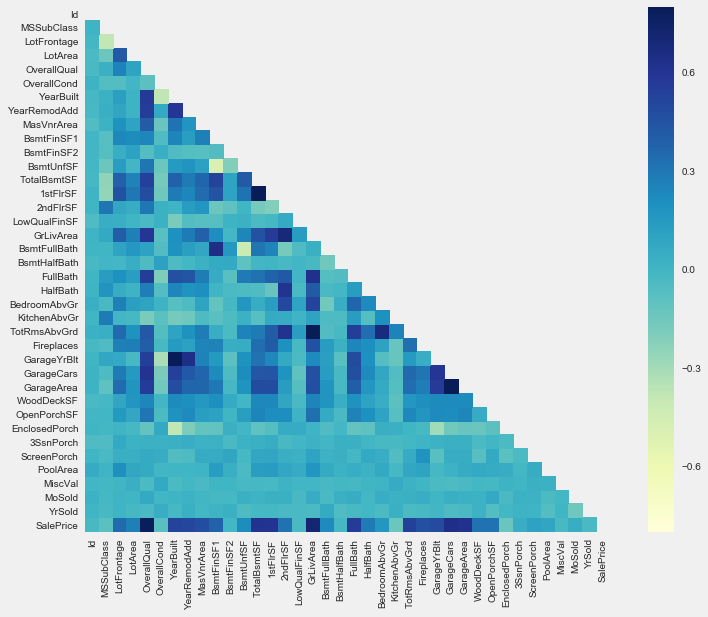

In [3]:
corrmat = df_train.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu", mask=mask);

**SalePrice has notable positive correlations with 1st Floor Sq. Foot, FullBath, and various Garage attributes. We also see some logical associations between features (eg, GarageCars & GarageArea, TotalBsmtSF & 1stFlrSF, YearBuilt & GarageYrBlt).  We can look for these paired correlations to watch for overfitting.**

**The strongest linear correlations we see for Saleprice are with OverallQual and GrLivArea. We examine these relationships further below**

**When examining the relationship between SalePrice vs. GrLivArea, we see two extreme outlier data points that do not follow the rather linear trend (greater than 4000 ft^2 Living Area but below 300k selling price). Based on our inituitive understanding of the relationship between square footage of a property and its price, and since these outliers makes up only 0.1% of the train data, we remove them to increase our chances that our model generalizes well to new data**

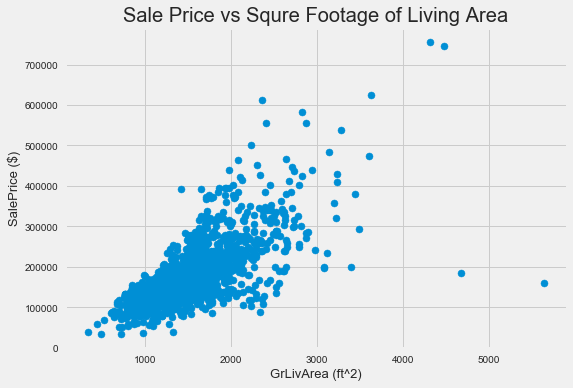

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.title('Sale Price vs Squre Footage of Living Area')
plt.ylabel('SalePrice ($)', fontsize=13)
plt.xlabel('GrLivArea (ft^2)', fontsize=13)
plt.show()

In [5]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
df = df_train.append(df_test, ignore_index=True)

print("There are now {} examples in our total dataset".format(len(df.index)))

There are now 2917 examples in our total dataset


**When examining the relationship between SalePrice and OverallQual, we do not see any extreme data points that require further attention.**

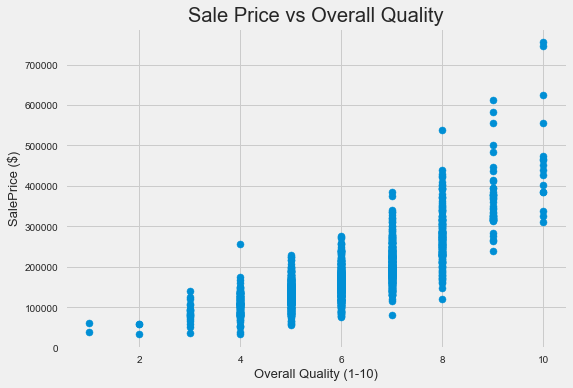

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['OverallQual'], y = df_train['SalePrice'])
plt.title('Sale Price vs Overall Quality')
plt.ylabel('SalePrice ($)', fontsize=13)
plt.xlabel('Overall Quality (1-10)', fontsize=13)
plt.show()

## 1.3 Missing Data

**We evaluate missing data in the combined train-test set, since NA's may need to be filled for both fitting models and predicting on new data.**

In [7]:
#Let's examine how much missing data we have
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Observations Missing', 'Percent of Column Missing'])
missing_data.head(10)

,Total Observations Missing,Percent of Column Missing
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
SalePrice,1459,0.500171
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageFinish,159,0.054508
GarageCond,159,0.054508
GarageQual,159,0.054508


**There are 4 fields missing more than half of data points (we disregard SalesPrice, since labels are missing from the test data)**

## 2. Data Clean Up

### 2.1 Drop LotFrontage and Utilities

**We drop Lot Frontage and Utilities for different reasons. Lot Frontage would require almost 17% of data to be imputed, and we do not have enough information to confidently impute. Utilities lacks predicitve power and has almost zero variation in the data (all entries are same value "AllPub" except for 1 "NoSeWa", which is in the training set)**

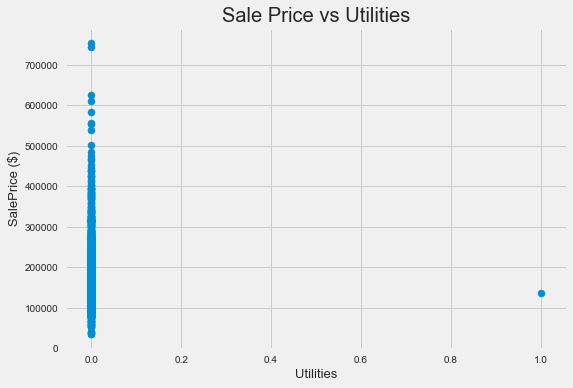

count       2915
unique         2
top       AllPub
freq        2914
Name: Utilities, dtype: object

The correlation between Utilities and SalePrice is -0.0143185194305


In [8]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['Utilities'].astype('category').cat.codes, y = df_train['SalePrice'])
plt.title('Sale Price vs Utilities')
plt.ylabel('SalePrice ($)', fontsize=13)
plt.xlabel('Utilities', fontsize=13)
plt.show()


print(df['Utilities'].describe())

print('\nThe correlation between Utilities and SalePrice is', 
      np.corrcoef(df_train['Utilities'].astype('category').cat.codes, df_train['SalePrice'])[0,1])


In [9]:
df = df.drop(['LotFrontage'],axis=1)
df = df.drop(['Utilities'], axis=1)

### 2.2 Fill Missing Data

**Based on the data description documentation on Kaggle, we could fill in a majority of the missing data** 

In [10]:
#Based on documentation can assume following for missing values
df['PoolQC'] = df['PoolQC'].fillna('No Pool')
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Alley'] = df['Alley'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('No Garage')
df['GarageType'] = df['GarageType'].fillna('No Garage')
df['GarageFinish'] = df['GarageFinish'].fillna('No Garage')
df['GarageQual'] = df['GarageQual'].fillna('No Garage')
df['BsmtCond'] = df['BsmtCond'].fillna('No Basement')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('No Basement')
df['BsmtQual'] = df['BsmtQual'].fillna('No Basement')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('No Basement')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No Basement')
df["Functional"] = df["Functional"].fillna("Typ")


**For most of the continuous data, we used the documentation, as well as data from related attributes to fill in 0 for missing values. For other variables, if there were only 1-2 observations missing in the column, we chose to fill in data with the most common value**

In [11]:
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
df['GarageCars'] = df['GarageCars'].fillna(0)
df['GarageArea'] = df['GarageArea'].fillna(0)
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0]) #RL
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0]) #TA
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['MasVnrType'] = df['MasVnrType'].fillna('None')

## 3. Binning

**To reduce our feature space prior to binarizing our data, we decided to bin year data into smaller categories (pre 1950, 1950 - 2000, and post-2000). We did this for year that the garage was built, year the house was remodeled, and year the house was built.**

In [12]:
#Bin year garage was built
df['GarageYrBlt'] = df['GarageYrBlt'].fillna('0') #Set to 0 if no garage

df.loc[(df["GarageYrBlt"].apply(int) < 1950) & (df["GarageYrBlt"].apply(int) > 0), "GarageBlt"] = 'Before1950'
df.loc[df["GarageYrBlt"].apply(int) >= 2000, "GarageBlt"] = '2000OrLater'
df.loc[(df["GarageYrBlt"].apply(int) < 2000) & (df["GarageYrBlt"].apply(int) >= 1950), "GarageBlt"] = '1950to1999'
df = df.drop(['GarageYrBlt'],axis=1)

In [13]:
#Bin year house was remodeled
df.loc[df["YearRemodAdd"] == df["YearBuilt"], "YearRemodAdd"] = 0 #set to 0 if no remodel

df.loc[(df["YearRemodAdd"] < 1950) & (df["YearRemodAdd"] != 0), "YrRemodeled"] = 'Before1950' #there are no values in this category
df.loc[(df["YearRemodAdd"] < 2000) & (df["YearRemodAdd"] >= 1950), "YrRemodeled"] = '1950to1999'
df.loc[df["YearRemodAdd"] >= 2000, "YrRemodeled"] = '2000OrLater'
df = df.drop(['YearRemodAdd'],axis=1) #drop continuous column

In [14]:
#Bin year house was built
df.loc[df["YearBuilt"] < 1950, "YrBuilt"] = 'Before1950'
df.loc[(df["YearBuilt"] < 2000) & (df["YearBuilt"] >= 1950), "YrBuilt"] = '1950to1999'
df.loc[df["YearBuilt"] >= 2000, "YrBuilt"] = '2000OrLater'
df = df.drop(['YearBuilt'],axis=1) #drop continuous column

## 4. Transformations

**Below, we transform some numerical variables that are really categorical**

In [15]:
#The building class
df['MSSubClass'] = df['MSSubClass'].apply(str)

#Overall Condition
df['OverallCond'] = df['OverallCond'].astype(str)

#Year and month sold
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

## 5. Final Data Prep (Feature Identification, Normalization)

**Below, we first binarize our data, so as to seamlessly integrate categorical variables into our regression models. Next we apply a log transformation to our SalePrice (log (1 + SalePrice))for a variety of reasons:  
-- 1) Makes interpretation of model coefficients more intutive, looking at a percent increase in housing price as opposed to dollar increase.  
-- 2) Revealed more linear relationship between features and outcome, which was evident by reduced error in our models.  
-- 2) Calculation of error made simpler, as we have already performed one of the transformations neccessary for Root-Mean Squared Log Error.**

**The purpose of adding a 1 to the SalePrice prior to taking the logarithm was to ensure that we never run into a scenario where we encounter a log(0) when calculating error (ie. when SalePrice is = 0).**  

**Lastly we standardized our data, so that determination of feature importance in models wasnt influenced by different scaling factors.**


In [16]:
#Create dummy variables
df = pd.get_dummies(df)

#Split off our outcome variable
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y = np.log1p(df["SalePrice"])
df = df.drop(["SalePrice"],axis = 1)
df = df.drop(["Id"],axis = 1)

#Track our feature space
features = df.columns.values

#Perform Min-Max Feature Scaling
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

print("After adding dummy variables for the categories, we now have {} features".format(df.shape[1]))

After adding dummy variables for the categories, we now have 341 features


In [17]:
#Relabel dataframe with feature names
df.columns = features
df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,YrSold_2009,YrSold_2010,GarageBlt_1950to1999,GarageBlt_2000OrLater,GarageBlt_Before1950,YrRemodeled_1950to1999,YrRemodeled_2000OrLater,YrBuilt_1950to1999,YrBuilt_2000OrLater,YrBuilt_Before1950
0,0.109641,0.413559,0.0,0.375,0.176060,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.194917,0.000000,0.0,0.375,0.243890,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.123083,0.419370,0.0,0.375,0.121197,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.131695,0.366102,0.0,0.375,0.053865,0.0,0.333333,0.0,0.231164,0.268775,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.170342,0.509927,0.0,0.500,0.163342,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Redefine Train and Test Data Sets

**Post data cleansing and transformation, we re-declare our train and test data sets for fitting and prediction**

In [18]:
test_data = df[1458:]
test_labels = y[1458:]
df = df[:1458] #train and dev data
y = y[:1458] #train and dev label
print(len(df.index)) #confirm length is correct

1458


## 6. Root Mean Square Least Error Functions for Scoreing

**The rmsle_cv function allowed us to use cross-validation in our regression models, to ensure that our findings for rmsle were robust to different permutations of train/dev splits.**

In [19]:
n_folds = 10

def rmsle_cv(model, x):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(x)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

my_scorer = make_scorer(rmsle, greater_is_better=False)

# Model Development

## 1. Regression

**Below is the 3-step process we took for building our best model:  
--1) Linear regression with L1 Regularization for feature selection- Lasso Model  
--2) Linear regression with L2 Regularization without built-in feature selection - Ridge Model  
--3) Linear regression with L2 Regularization with built-in feature selection - non-zero Lasso features input into Ridge Model**

### Step 1 - Lasso

**The first step we took was to run Linear regression with L1 Regularization for feature selection- also known as Lasso Model. This model outputs a sparse matrix and has built-in feature selection due to the number of coefficients that return a value of zero. After using brute-force testing of different alpha values, and evaluating the different Lasso models using k fold cross-validation, we find the optimal alpha to be 0.0001 for Lasso with an average RMSLE of 0.1113. The non-zero features output by this optimal alpha value was used as an input in Step 3 (Ridge Model with feature selection).**

The smallest rmsle achieved by this model is 0.1114 and occurs when alpha is 0.0001


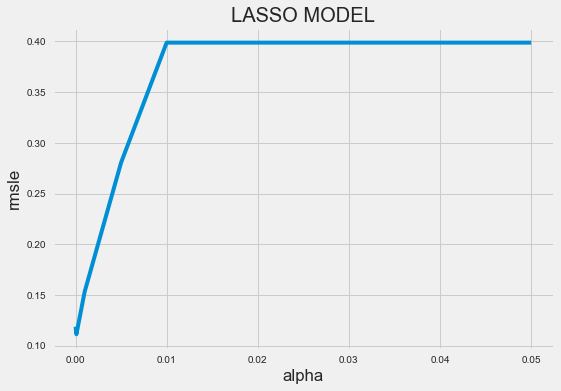

In [20]:
def Lasso_fn(alphas):
    rmsle_list = []
    for i in alphas:
        lassoReg = Lasso(alpha=i, normalize=True)
        rmsle_list.append(rmsle_cv(lassoReg, df.values))
    plt.plot(alphas,rmsle_list)
    plt.xlabel("alpha")
    plt.ylabel("rmsle")
    plt.title("LASSO MODEL")
    print("The smallest rmsle achieved by this model is {0:.4f} and occurs when alpha is {1}"
          .format(min(rmsle_list), alphas[np.argmin(rmsle_list)]))
    return alphas[np.argmin(rmsle_list)]
    
    
alphas = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05]
min_alpha_Lasso = Lasso_fn(alphas)

lassoReg = Lasso(alpha=min_alpha_Lasso, normalize=True)
lassoReg.fit(df,y)
pred = lassoReg.predict(test_data)
test_preds = np.exp(pred) - 1

pred_df = pd.DataFrame({"SalePrice":test_preds, "Id": df_test['Id']})

pred_df.to_csv('submission_lasso.csv', index = False)

### Step 2 - Ridge

**The second step we took was to run Linear regression with L2 Regularization without built-in feature selection- also known as Ridge Model. This model outputs a dense matrix as there are little to no coefficients that return a value of zero. After using brute-force testing of different alpha values, and evaluating the different Ridge models using k fold cross-validation, we find the optimal alpha to be 0.3 for Ridge with an average RMSLE of 0.1159; slightly higher than our findings from the Lasso model. Our team initially planned on using this optimal alpha of 0.3 for the Ridge model in Step 3, but found through hyperparameter tuning that the optimal alpha for our Ridge model in Step 3 is different than Step 2; most likely due to the smaller feature space in Step 3.**

The smallest rmsle achieved by this model is 0.1159 and occurs when alpha is 0.3


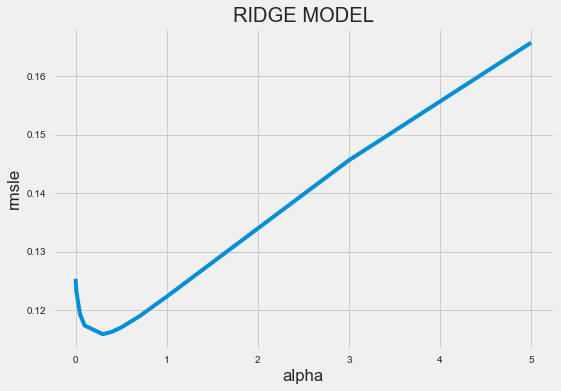

In [21]:
def Ridge_fn(alphas):
    rmsle_list = []
    for i in alphas:
        ridgeReg = Ridge(alpha=i, normalize=True)
        rmsle_list.append(rmsle_cv(ridgeReg, df.values))
    plt.plot(alphas,rmsle_list)
    plt.xlabel("alpha")
    plt.ylabel("rmsle")
    plt.title("RIDGE MODEL")
    print("The smallest rmsle achieved by this model is {0:.4f} and occurs when alpha is {1}"
          .format(min(rmsle_list), alphas[np.argmin(rmsle_list)]))
    best_alpha = alphas[np.argmin(rmsle_list)]
    ridgeReg = Ridge(alpha= best_alpha, normalize=True)
    ridgeReg.fit(df,y)
    pred = ridgeReg.predict(test_data)
    transformed_pred = np.exp(pred) - 1
    return transformed_pred


alphas = [0.001,0.01,0.05,0.1, 0.3, 0.4, 0.5, 0.7, 1, 3, 5]
test_preds = Ridge_fn(alphas)
pred_df = pd.DataFrame({"SalePrice":test_preds, "Id": df_test['Id']})

pred_df.to_csv('submission_ridge.csv', index = False)

### Step 3 - Input non-zero features from Lasso model as features for Ridge model

**The last step we took for this model was to use the non-zero features from a Linear regression with L1 as an input to a linear regression with L2 Regularization, thus resulting in a more parsimonious model that can still reap the benefits a high-weight penalization. We found that 224 features of the 341 features from the Lasso model had a coefficent of 0. This resulted in only 117 features being input into our Ridge model. After using brute-force testing of different alpha values for the Ridge portion of the model (we used the optimal alpha value from Step 1 for the Lasso portion of the model), and evaluating using k fold cross-validation, we find the optimal alpha to be 0.05 for Ridge. The best rmsle we found for this Ridge Lasso model was 0.1068; higher than our findings from both individual Ridge model and Lasso model.**

Lasso picked 117 variables and eliminated the other 224 variables
The smallest rmsle achieved by this model is 0.1068 and occurs when alpha for Ridge is 0.05


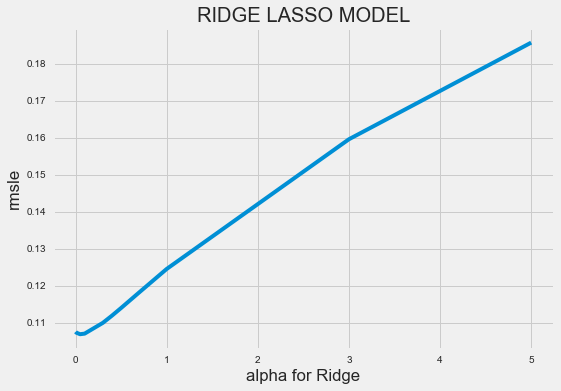

In [22]:
def Lasso_Ridge(df,L_alpha, R_alpha):
    rmsle_list = []
    lassoReg = Lasso(alpha=L_alpha, normalize= True)
    lassoReg.fit(df,y)
    coef = pd.Series(lassoReg.coef_, index = df.columns)
    nz_feats = coef[coef != 0]
    new_df = df[list(nz_feats.index)]
    print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

    for i in R_alpha:
        ridgeReg2 = Ridge(alpha=i, normalize=True)
        rmsle_list.append(rmsle_cv(ridgeReg2, new_df.values))

    print("The smallest rmsle achieved by this model is {0:0.4f} and occurs when alpha for Ridge is {1}"
      .format(min(rmsle_list), alphas[np.argmin(rmsle_list)]))    
    plt.plot(R_alpha,rmsle_list)
    plt.xlabel("alpha for Ridge")
    plt.ylabel("rmsle")
    plt.title("RIDGE LASSO MODEL")
    
    best_alpha = alphas[np.argmin(rmsle_list)]
    ridgeReg = Ridge(alpha= best_alpha, normalize=True)
    ridgeReg.fit(new_df,y)
    pred = ridgeReg.predict(test_data[list(nz_feats.index)])
    transformed_pred = np.exp(pred) - 1
    return transformed_pred

    
R_alpha = [0.001,0.01,0.05,0.1, 0.3, 0.4, 0.5, 0.7, 1, 3, 5]    
L_alpha = min_alpha_Lasso
test_preds = Lasso_Ridge(df,L_alpha, R_alpha)
pred_df = pd.DataFrame({"SalePrice":test_preds, "Id": df_test['Id']})

pred_df.to_csv('submission_ridge_lasso.csv', index = False)

### Predicting on Test Data

**Our 3 models from the steps above were all used to predict on the test data, and submitted on Kaggle. We received the following rmsle results:**  
-- **Step 1: Lasso Model- RMSLE of 0.1266 for predictions on test data**  
-- **Step 2: Ridge Model- RMSLE of 0.1309 for predictions on test data**  
-- **Step 3: Lasso-Ridge combination Model- RMSLE of 0.1305 on test data**  

**We see that our Lasso model ended up generalizing the best, even though the combination model gave the best results when evaluating rmsle through cross validation. Each model performs slightly worse on the test data, which is to be expected seeing that new observations may have relationships between features that the training data did not. For example, if we were to fit a model using L1 regularization on the test data, as opposed to the training data, we would see some non-zero features in our Lasso training model receive a 0 coefficient in the test model. Likewise, if we were to fit a model using L2 regularization on the test data, as opposed to the training data, we could also see some considerably different coefficient values between the training model and the test model.** 